In [19]:
import pandas as pd
import numpy as np
import glob

input = 'submissions-transformed/part-*.json.gz'

# Initial Data Analysis

In [4]:
# read in the transformed data
etl_filename = glob.glob(input)[0]
submissions = pd.read_json(etl_filename, lines=True)

In [5]:
submissions.dtypes

created_on        int64
age               int64
year              int64
month             int64
day               int64
hour              int64
day_of_week       int64
subreddit        object
author           object
post_count        int64
over_18           int64
gilded            int64
archived        float64
quarantine        int64
stickied          int64
num_comments      int64
score             int64
title_length      int64
title            object
selftext         object
dtype: object

In [7]:
# 257121 number of submissions in dataset
submissions.shape

(257121, 20)

In [9]:
# View summary stats
submissions[['post_count', 'gilded',  'num_comments', 'score']].describe()

,post_count,gilded,num_comments,score
count,257121.000000,257121.000000,257121.000000,257121.000000
mean,47.843782,0.001330,16.502565,53.211041
std,124.337315,0.049324,310.699312,1255.202270
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,1.000000
50%,6.000000,0.000000,4.000000,2.000000
75%,28.000000,0.000000,10.000000,4.000000
max,1065.000000,9.000000,59146.000000,111063.000000


# Plot Basic Visualizations of Data

In [12]:
import matplotlib.pyplot as plt

### Distribution of Score and Comments

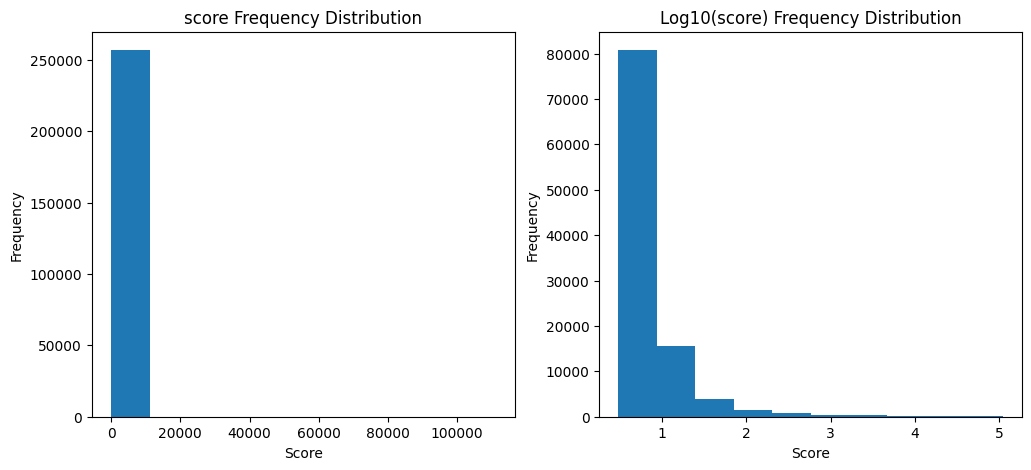

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].hist(submissions['score'])
axes[0].set_title('Score Frequency Distribution')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

scores = submissions['score'].values
scores = scores[scores > 2]
scores = np.log10(scores)
axes[1].hist(scores)
axes[1].set_title('Log10(Score) Frequency Distribution')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Frequency')

fig.show()

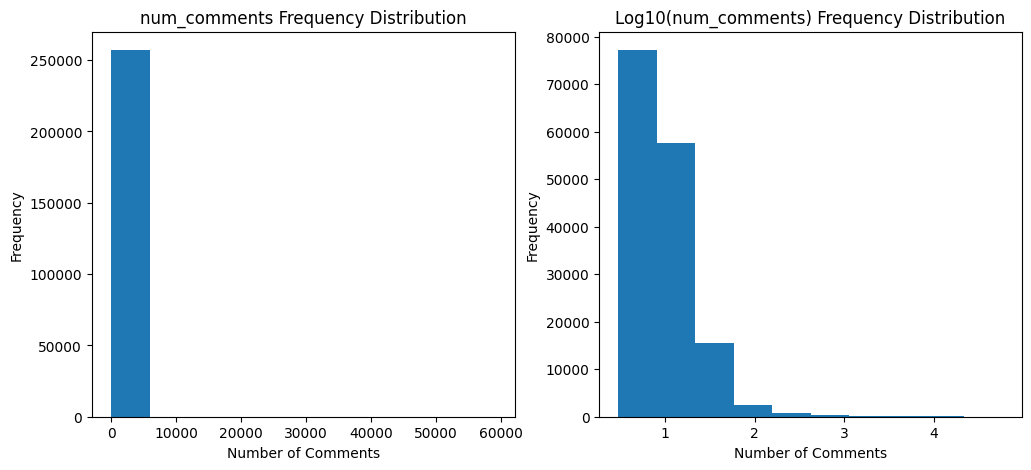

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].hist(submissions['num_comments'])
axes[0].set_title('num_comments Frequency Distribution')
axes[0].set_xlabel('Number of Comments')
axes[0].set_ylabel('Frequency')

comments = submissions['num_comments'].values
comments = comments[comments > 2]
comments = np.log10(comments)
axes[1].hist(comments)
axes[1].set_title('Log10(num_comments) Frequency Distribution')
axes[1].set_xlabel('Number of Comments')
axes[1].set_ylabel('Frequency')

fig.show()

## Scatter Plots: time vs score and time vs comments

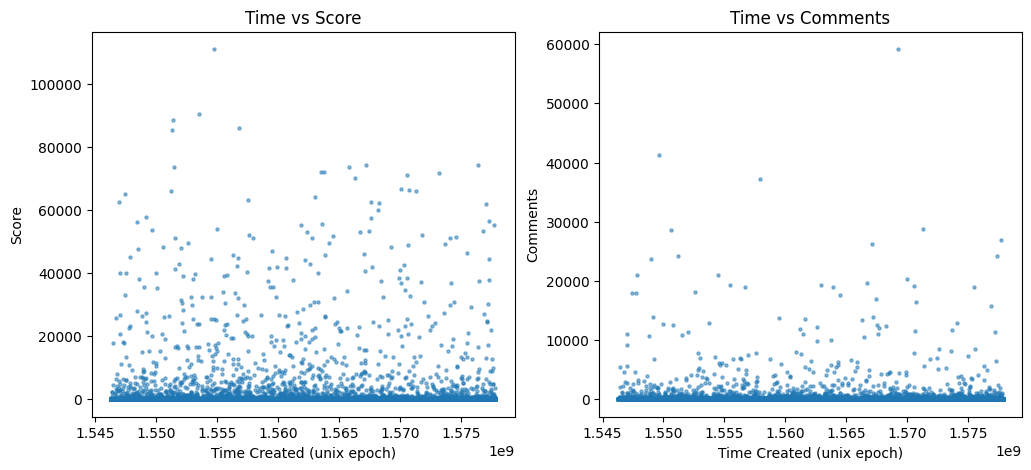

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(submissions['created_on'], submissions['score'], alpha=0.5, s=5 )
axes[0].set_title('Time vs Score')
axes[0].set_xlabel('Time Created (unix epoch)')
axes[0].set_ylabel('Score')

axes[1].scatter(submissions['created_on'], submissions['num_comments'], alpha=0.5, s=5 )
axes[1].set_title('Time vs Comments')
axes[1].set_xlabel('Time Created (unix epoch)')
axes[1].set_ylabel('Comments')

fig.show()